Тестовое задание
================

## SQL

В *SQLite* файле `issues.db` находится таблица `history`.

Таблица содержит следующие колонки:
* `issue_key` – уникальный ключ задачи
* `status` – статус задачи
* `minutes_in_status` – количество минут, которое задача находилась в статусе
* `previous_status` – предыдущий статус задачи
* `status_begin` – время перехода задачи в текущий статус
* `status_end` – время окончания нахождения задачи в текущем статусе

Время `status_begin` и `ended_at` указаны в формате unix epoch в *миллисекундах*.

In [1]:
# Импорт необходимых библиотек
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from prettytable import PrettyTable

### Задача 1

Напишите SQL запрос, который для всех задач, открытых на момент времени `T`, выведет:
* ключ задачи
* время создания задачи
* статус на момент `T`

Задача считается открытой на момент времени `T`, если к этому времени последний статус задачи был любой кроме `Closed` и `Resolved`.

Оформите запрос таким образом, чтобы, изменив дату, его можно было использовать для поиска открытых задач в любой момент времени как в прошлом, так и в настоящем.

Здесь и далее все даты и времена должны быть переведены в удобочитаемый вид.

In [2]:
# Момент времени T
T = "2023-11-15"

In [3]:
# Подключение к БД и составление запроса
connection = sqlite3.connect('issues.db')
cursor = connection.cursor()
cursor.execute('''
--Таблица с датами создания задач
WITH dt_create AS (
SELECT
  issue_key,
  MIN(strftime('%Y-%m-%d', datetime(status_begin / 1000, 'unixepoch'))) AS issue_creation_dt
FROM history
GROUP BY issue_key),

-- Таблица с открытыми статусами на момент Т
t_moment_status AS (
SELECT
  issue_key,
  MAX(strftime('%Y-%m-%d', datetime(status_begin / 1000, 'unixepoch'))) as dt_of_status,
  status as status_at_t_moment
FROM history
WHERE
  strftime('%Y-%m-%d', datetime(status_begin / 1000, 'unixepoch')) <= strftime('%Y-%m-%d', ?)
GROUP BY issue_key
HAVING status NOT IN ('Closed', 'Resolved'))

-- Объединённая таблица (с сохранением данных из левой таблицы t_moment_status)
SELECT t_moment_status.issue_key,
       dt_create.issue_creation_dt,
       t_moment_status.status_at_t_moment
FROM t_moment_status
     LEFT JOIN dt_create
     ON t_moment_status.issue_key = dt_create.issue_key
LIMIT 10
''', (T,))

# Сохранение запроса в переменную, визуализация, закрытие соединения
results = cursor.fetchall()
table = PrettyTable()
table.field_names = [description[0] for description in cursor.description]

for row in results:
    table.add_row(row)
display(table)

connection.close()

issue_key,issue_creation_dt,status_at_t_moment
A-23481,2020-04-22,Open
A-23521,2020-04-23,Open
A-23563,2020-04-25,Open
A-23565,2020-04-25,Open
A-26092,2020-08-31,In Owl
A-28405,2020-11-30,In Progress
A-28782,2020-12-11,Waiting for integration
A-31006,2021-03-01,Open
A-31053,2020-10-21,Open
A-31353,2021-03-16,Waiting for integration


Выводы:
- составлен SQL запрос, который для всех задач, открытых на момент времени `T`,
  <br>выводит ключ задачи, время создания задачи, статус на момент `T`
- в запросе использовано объединение двух временных таблиц
- даты переведены в удобочитаемый формат
- момент времени `T` вынесен в отдельную ячейку
- вывод запроса ограничен 10-ю строками (это ограничение можно убрать)

## Pandas

Файл `task_history.csv` содержит исторические данные системы сборки (e.g. *jenkins*, *teamcity*, etc.)

Каждая запись в истории описывает отдельный запуск задачи `build_name` на рабочей машине `worker`.<br/>
Для любого запуска известны автор `author` и проект `project`, в рамках которого был запущен расчет данной задачи.

In [4]:
# Загрузка данных и вывод общей информации
df = pd.read_csv('task_history.csv')
df.info(0)
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160492 entries, 0 to 160491
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   task_id      160492 non-null  int64 
 1   start_time   160492 non-null  object
 2   finish_time  160492 non-null  object
 3   status       160492 non-null  object
 4   worker       160492 non-null  object
 5   build_name   160492 non-null  object
 6   author       160492 non-null  object
 7   project      160492 non-null  object
dtypes: int64(1), object(7)
memory usage: 9.8+ MB


,task_id,start_time,finish_time,status,worker,build_name,author,project
8841,61988,2005-06-23 20:56:27.448,2005-06-23 22:34:42.827,success,worker_22,validate_yellow_data,Bendy Python,Mud Runner
25796,98161,2005-06-21 08:31:58.792,2005-06-21 08:49:31.673,success,worker_35,deploy_yellow_library,Julia Ivanov,Mud Runner
105104,74074,2005-07-11 21:33:12.462,2005-07-11 21:47:33.771,success,worker_0f,build_cyan_texture,Bendy Python,Timeshift
82562,197788,2005-07-15 16:23:42.236,2005-07-15 16:28:16.485,success,worker_75,build_cyan_texture,Bendy Python,Timeshift
92837,203773,2005-07-13 15:42:19.731,2005-07-13 15:48:16.003,success,worker_0c,deploy_cyan_texture,Bendy Python,Timeshift


### Задача 2

Для каждой недели распечатайте топ-3 пользователей, потребивших наибольшее количество машиночасов (количество часов, затраченных машиной на обработку задачи).

Выведите для данных пользователей процент потребленных ресурсов от общего объема расчетов за эту неделю.

In [5]:
# Преобразование столбцов 'start_time' и 'finish_time' в тип данных datetime
df['start_time'] = pd.to_datetime(df['start_time'])
df['finish_time'] = pd.to_datetime(df['finish_time'])

In [6]:
# Рассчет длительности выполнения каждой задачи в часах
df['duration'] = (df['finish_time'] - df['start_time']).dt.total_seconds() / 3600

In [7]:
# Группировка данных по неделям и пользователям, суммируя продолжительность выполнения задачи и общий объем расчетов.
weekly_stats = df.groupby([pd.Grouper(key='start_time', freq='W'), 'author']).agg({'duration': 'sum', 'project': 'count'}).reset_index()
weekly_stats.columns = ['week', 'author', 'total_duration', 'total_tasks']

In [8]:
# Топ-3 пользователей с наибольшим количеством машиночасов для каждой недели
top_users = weekly_stats.groupby('week').apply(lambda x: x.nlargest(3, 'total_duration')).reset_index(drop=True)

In [9]:
# Рассчёт процента потреблённых ресурсов от общего объёма расчётов за каждую неделю.
weekly_stats['resource_percentage'] = (weekly_stats['total_duration'] / weekly_stats['total_duration'].sum()) * 100

In [10]:
# Печать результатов
for week, group in top_users.groupby('week'):
    print(f"Week: {week}")
    for index, row in group.iterrows():
        author = row['author']
        duration = round(row['total_duration'], )
        percentage = round(weekly_stats.loc[(weekly_stats['week'] == week) & (weekly_stats['author'] == author), 'resource_percentage'].values[0], 2)
        print(f"Author: {author}, Duration: {duration} hours, Percentage: {percentage}%")
    print()

Week: 2005-06-26 00:00:00
Author: Bendy Python, Duration: 4139 hours, Percentage: 10.08%
Author: Marsha Koltron, Duration: 428 hours, Percentage: 1.04%
Author: Java Smoozy, Duration: 271 hours, Percentage: 0.66%

Week: 2005-07-03 00:00:00
Author: Bendy Python, Duration: 4814 hours, Percentage: 11.72%
Author: Marsha Koltron, Duration: 757 hours, Percentage: 1.84%
Author: John Ivanov, Duration: 532 hours, Percentage: 1.3%

Week: 2005-07-10 00:00:00
Author: Bendy Python, Duration: 4257 hours, Percentage: 10.37%
Author: Java Smoozy, Duration: 515 hours, Percentage: 1.25%
Author: Eric Smith, Duration: 346 hours, Percentage: 0.84%

Week: 2005-07-17 00:00:00
Author: Bendy Python, Duration: 4130 hours, Percentage: 10.06%
Author: Kenny Ivanov, Duration: 378 hours, Percentage: 0.92%
Author: John Koltron, Duration: 285 hours, Percentage: 0.69%



Выводы:
- Для каждой недели распечатаны топ-3 пользователей, потребивших наибольшее количество машиночасов.
- Для данных пользователей распечатан процент потребленных ресурсов от общего объёма расчётов за эту неделю.

### Задача 3

Отобразите график с ежедневным потреблением машинного времени каждым проектом.

Для визуализации можно использовать следующие библиотеки: `matplotlib`, `seaborn` или `altair`.

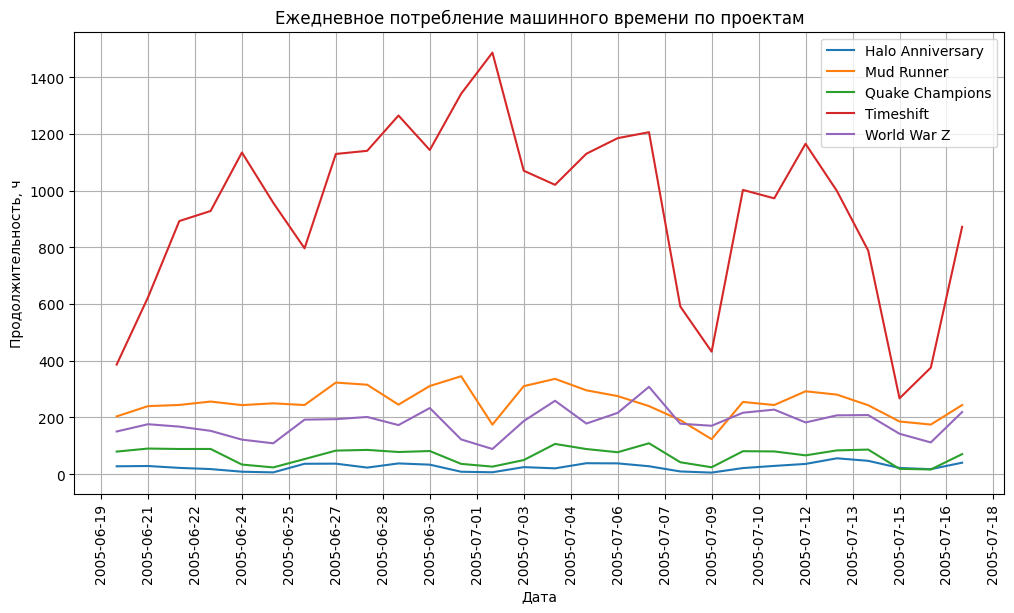

In [11]:
# Подготовка данных
daily_usage = df.groupby([df['start_time'].dt.date, 'project'])['duration'].sum().reset_index()
daily_usage.columns = ['date', 'project', 'duration']

# Построение диаграммы
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_usage, x='date', y='duration', hue='project')
plt.xlabel('Дата')
plt.ylabel('Продолжительность, ч')
plt.title('Ежедневное потребление машинного времени по проектам')
plt.legend()
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(len(daily_usage['date'].unique())))
plt.grid()
plt.show()

Выводы:
- для визуализации выбрана линейная диаграмма, т.к. столбчатая получается перегруженной внизу
- диаграмма демонстрирует, что основным проектом в обозначенный период был `Timeshift`
- второе место по затраченному времени разделили `Mud Runner` и `World War Z`
- проекты, на которые было выделено меньше всего времени: `Halo Anniversary` и `Quake Champions`

### Задача 4

Рассмотрим *еженедельное* общее потребление ресурсов. На второй неделе можно заметить всплеск нагрузки с ее последующим планомерным снижением.

Проанализируйте предоставленные данные и найдите, с чем связано подобное поведение.

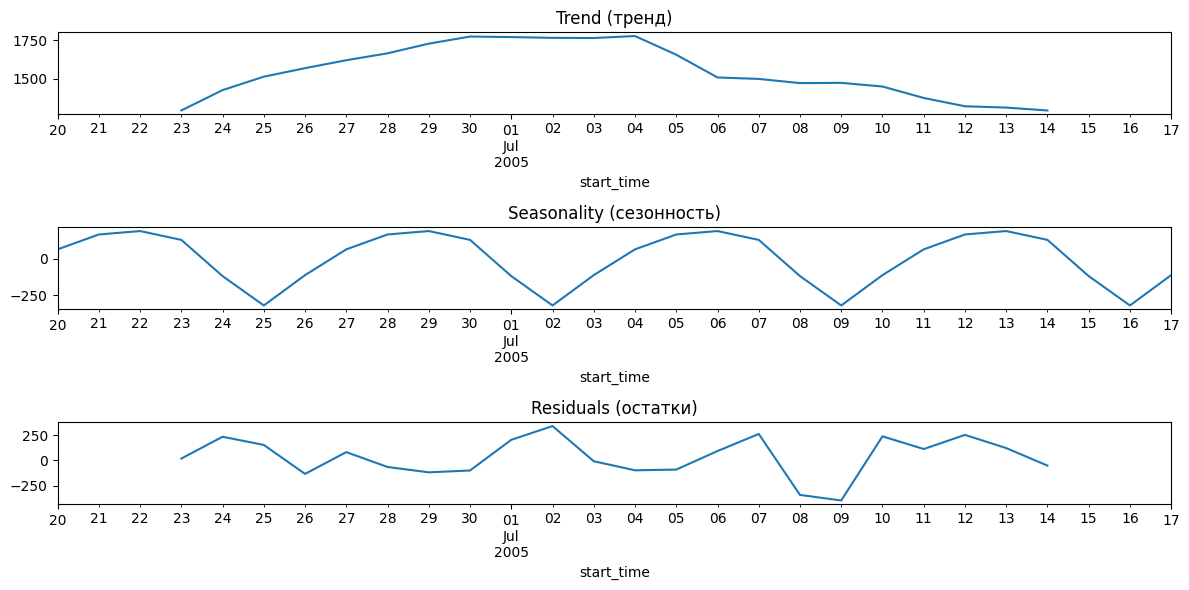

In [12]:
# Создание копии датафрейма, её ресемплинг по дням
df_s = df.copy().set_index('start_time')['duration']
df_resample = df_s.resample('D').sum()
decomposed_df = seasonal_decompose(df_resample)

# Визуализация тренда и сезонности
plt.figure(figsize=(12,6))

plt.subplot(311)
decomposed_df.trend.plot(ax=plt.gca())
plt.title('Trend (тренд)')

plt.subplot(312)
decomposed_df.seasonal.plot(ax=plt.gca())
plt.title('Seasonality (сезонность)')

plt.subplot(313)
decomposed_df.resid.plot(ax=plt.gca())
plt.title('Residuals (остатки)')
plt.tight_layout()

Выводы:
- анализ графика сезонности:
  - со среды начинается снижение общих трудозатрат с минимумом в воскресенье
  - с понедельника работа над проектами увеличивается с максимумом в среду
- анализ графика тренда:
    - равномерный рост нагрузки в первую неделю
    - максимальная нагрузка на протяжении второй недели
    - снижение - на третьей
- можно сделать предположение, что такое поведение связано с проектом `Timeshift`:
    - нагрузка по остальным проектам практически не меняется
    - вероятно, в обозначенный период времени данный проект получил высший приоритет
      <br>и возникла потребность в его скорейшем запуске.